# Amazon Product Recommender

**Jason Truong**  **|**  Jasontruong19@gmail.com  **|**  September 25, 2022

**Problem Statement:** based on a person’s review of a product, can items of similar properties be recommended to them such that they are more inclined to buy the item? This project adds business value by improving the customer buying experience on Amazon through personalized recommendations for products. These recommendations influence customer purchases by making it easier for customers to find similar products. 

***

# 3 Natural Language Processing Analysis

**Note**: This is notebook **4 of 5** for building the recommendation system.

# Table of Contents

1. **[Introduction](#1Introduction)**  
2. **[Preliminary Data Setup](#2Preliminary)**  
    2.1. [Preprocessing: 'Overall'](#2_1Overall)  
    2.2. [Preprocessing: 'reviewScore'](#2_2Review)  
    2.3. [Preprocessing: 'Vote'](#2_3Vote)  
    2.4. [Drop duplicates and NaNs](#2_4Drop)  
3. **[Test/Train Setup](#3Test_Train)**  
4. **[NLP Analysis Setup](#4NLP)**  
5. **[Advanced Models](#5AdvancedModels)**  
    5.1. [Logistic Regression](#5.1logit)  
    5.2. [Decision Tree Model](#5.2DT)  
    5.3. [XGBoost](#5.3xgboost)  
6. **[Summary](#6Summary)**

# 1. Introduction<a class ='anchor' id='1Introduction'></a>

Notebook 2_Modelling_without_text_data explored different models and the numeric features' impact on sentiment prediction. The findings indicated that the numeric features do not impact the sentiment predictions. In this notebook, the review text will be turned into numeric features and then the same models will be used to determine if these new features have an impact on the sentiment prediction. The expected result is that the sentiment is highly dependent on what's written in the review text because if a person loves or hates a product, they would turn their feelings into words for the review.


# 2. Preliminary Data Setup<a class ='anchor' id='2Preliminary'></a>

In [1]:
# Import packages
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import plotting functions
from utils import class_report , conf_matrix


Load in the preprocessed dataset.

In [2]:
review_df = pd.read_json('preprocessed_review.json')

In [3]:
review_df.info(show_counts= True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1698253 entries, 0 to 1698252
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   reviewScore         1698253 non-null  int64 
 1   verified            1698253 non-null  int64 
 2   reviewerID          1698253 non-null  object
 3   product_id          1698253 non-null  object
 4   reviewText          1698253 non-null  object
 5   summary             1698253 non-null  object
 6   vote                1698253 non-null  int64 
 7   reviewDay           1698253 non-null  int64 
 8   reviewMonth         1698253 non-null  int64 
 9   reviewYear          1698253 non-null  int64 
 10  style_Amazon Video  1698253 non-null  int64 
 11  style_Blu-ray       1698253 non-null  int64 
 12  style_DVD           1698253 non-null  int64 
 13  style_Other         1698253 non-null  int64 
 14  style_VHS Tape      1698253 non-null  int64 
dtypes: int64(11), object(4)
memory u

Looking at the processed data, 4 columns are non-numeric. The column of interest is the `reviewText` column so the other object columns will not be included.

In [4]:
review_df.head()

,reviewScore,verified,reviewerID,product_id,reviewText,summary,vote,reviewDay,reviewMonth,reviewYear,style_Amazon Video,style_Blu-ray,style_DVD,style_Other,style_VHS Tape
0,5,1,A1HP3B92A3JDQ1,0005019281,Of course it's impossible to separate Henry Wi...,The Fonz as Scrooge,4,2,11,2002,0,0,1,0,0
1,5,0,AZB4CQ9JZSUQB,0005019281,"When this first aired in 1979, I enjoyed it so...",A Christmas Carol to be remembered,3,28,1,2002,0,0,1,0,0
2,5,0,A1PXS5N63PS6WR,0005019281,I must confess to being a bit of a coinsure of...,Change can be good,2,12,12,2001,0,0,1,0,0
3,3,0,A17TPT3FWAE5T1,0005019281,If you already have (and love) the Alistair Si...,An interesting contrast to more traditional ve...,31,11,12,2001,0,0,0,0,1
4,4,0,A3P98J5DZ00A75,0005019281,Henry Winkler proves his acting ability in thi...,grey,62,19,10,2001,0,0,1,0,0


The first step is to only focus on the sentiment of the review to try to predict the overall sentiment so every other column will be dropped. A separate analysis will be done to include the summary text if time permits.

In [5]:
# Only keep the necessary columns
review_df = review_df[['reviewScore', 'reviewText','reviewerID','product_id']]
review_df

,reviewScore,reviewText,reviewerID,product_id
0,5,Of course it's impossible to separate Henry Wi...,A1HP3B92A3JDQ1,0005019281
1,5,"When this first aired in 1979, I enjoyed it so...",AZB4CQ9JZSUQB,0005019281
2,5,I must confess to being a bit of a coinsure of...,A1PXS5N63PS6WR,0005019281
3,3,If you already have (and love) the Alistair Si...,A17TPT3FWAE5T1,0005019281
4,4,Henry Winkler proves his acting ability in thi...,A3P98J5DZ00A75,0005019281
...,...,...,...,...
1698248,5,Loved it want to see more,A1UM0LZVGQ4RYX,B0001GF2F6
1698249,5,Loved it wish it was more than two seasons.,A3MWE7P29CDR5L,B0001GF2F6
1698250,5,Such a witty show with good acting. This show ...,A3J6N3SOCENIPB,B0001GF2F6
1698251,4,It's a weird (comical) look at Grim Reapers.,A5O06SYSW6V93,B0001GF2F6


In [6]:
review_df['product_id'].value_counts()

B00006CXSS    24436
6305837325    16643
B00005JLF2    10032
7880879625     6695
0793906091     6379
              ...  
B00005JM48      100
B00000F2LK      100
B00003CY2S      100
6303261736      100
B00005LIRO      100
Name: product_id, Length: 3744, dtype: int64

In [7]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1698253 entries, 0 to 1698252
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   reviewScore  int64 
 1   reviewText   object
 2   reviewerID   object
 3   product_id   object
dtypes: int64(1), object(3)
memory usage: 64.8+ MB


## 2.2 Check the datatype in the column `reviewScore` <a class ='anchor' id='2_2Review'></a>

Split the reviewScore column to 'Good (value of 1)'  for reviews that are 4 or 5 and 'Bad (value of 0)' for reviews that are 1,2 or 3.

In [8]:
review_df['review_class'] = np.where(review_df['reviewScore']>=4,1,0)

In [9]:
review_df.head()

,reviewScore,reviewText,reviewerID,product_id,review_class
0,5,Of course it's impossible to separate Henry Wi...,A1HP3B92A3JDQ1,0005019281,1
1,5,"When this first aired in 1979, I enjoyed it so...",AZB4CQ9JZSUQB,0005019281,1
2,5,I must confess to being a bit of a coinsure of...,A1PXS5N63PS6WR,0005019281,1
3,3,If you already have (and love) the Alistair Si...,A17TPT3FWAE5T1,0005019281,0
4,4,Henry Winkler proves his acting ability in thi...,A3P98J5DZ00A75,0005019281,1


This new `review_class` column will be used for the different models to predict the sentiment from the `reviewText`.

# 3. Set up Train/Validation/Test split <a class ='anchor' id='3Test_Train'></a>

Since the dataset is 1,698,253 rows, a smaller amount will be sampled for the NLP analysis.

In [10]:
review_df.shape

(1698253, 5)

In [11]:
subsample = review_df.sample(frac = 0.05)

# Check results
subsample

,reviewScore,reviewText,reviewerID,product_id,review_class
1514740,1,I have seen the movie before and rate it a fiv...,A2DK4OC8T8T0JF,B00006CXSS,0
792859,5,Another fanatastic DVD collection. The first 2...,A160AB64G2E949,6304613113,1
736883,5,Brought back many old memories. Great quality...,A1RDLMZ0F5VHCW,6304359721,1
639402,2,Something is definitely wrong with this movie-...,A1GD8XJJZ5M8SD,6303949436,0
1386207,5,One of the best movies i have ever seen. Defia...,A2F042SD7FIFBO,B00005JPKE,1
...,...,...,...,...,...
68317,4,"I hadn't heard about this movie before, until ...",A24PMCQAMYOQML,0783116926,1
265133,5,"saw it with my father-in-law , who was there ,...",A2B0YLZ3PI54OB,6300268748,1
892436,5,Worth the waste of time for entertainment. Goo...,A2RG7JOI3ZYE01,6305475695,1
1083722,5,my favorite movie. Lots of book talk,A32W0Z6MJXPOIY,B00003CXDJ,1


In [12]:
from sklearn.model_selection import train_test_split

#Set up data for training, validation and testing
X = subsample.drop(columns = ['review_class', 'reviewScore'])
y = subsample['review_class']

# Stratify ensures that both the train and test set includes all the classes in the data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, stratify = y)


Check the split of the data for the train and test set

The training data contains 82.1% of positive reviews which means that the data is highly skewed towards positive reviews. There is a 82.1% chance of predicting the review sentiment correctly if every prediction made was positive.

In [13]:
y_test.value_counts()/y_test.shape[0]

1    0.833906
0    0.166094
Name: review_class, dtype: float64

The testing data contains 82.1% of positive reviews which means that the data is highly skewed towards positive reviews. There is an 82.1% chance of predicting the review sentiment correctly if every prediction made is positive.

# 4. Set up NLP analysis <a class ='anchor' id='4NLP'></a>

To turn the review text into numeric features, a vectorizer will be used to do so.

**Convert the text in the reviewText column to vectors**

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Instantiate 
# Discard stop words and any words that appear less than 25 times in the dataset of reviews.
review_wordbank = TfidfVectorizer(stop_words = "english", min_df = 25)

# 2. Fit the train data
review_wordbank.fit(X_train['reviewText'])

# 3. Transform
X_train_transformed = review_wordbank.transform(X_train['reviewText'])
X_test_transformed = review_wordbank.transform(X_test['reviewText'])

# Check results
X_train_transformed

<63684x7722 sparse matrix of type '<class 'numpy.float64'>'
	with 1485882 stored elements in Compressed Sparse Row format>

After preliminary vectorization with TfidfVectorizer, 63684 rows of reviews returned 7641 unique terms or tokens. This vectorizer combines the count of the word in the text with the inverse count of the word in every document to come up with a numeric representation. As the count of the word in the text increases, the numeric value increases. As the count of the word in the whole library of text increases, the numeric value decreases. This ensures that common words like movie will get a lower value because they may appear in every text.

The transformed words can be put into a dataframe to analyze which words appear the most.

In [15]:
word_counts = pd.DataFrame({"counts":X_train_transformed.toarray().sum(axis=0)},
                          index = review_wordbank.get_feature_names()
                          ).sort_values("counts",ascending= False)
# Check results
display(word_counts.head())

,counts
movie,4702.863294
great,3791.382455
good,2577.821221
love,2290.070921
classic,1330.815386


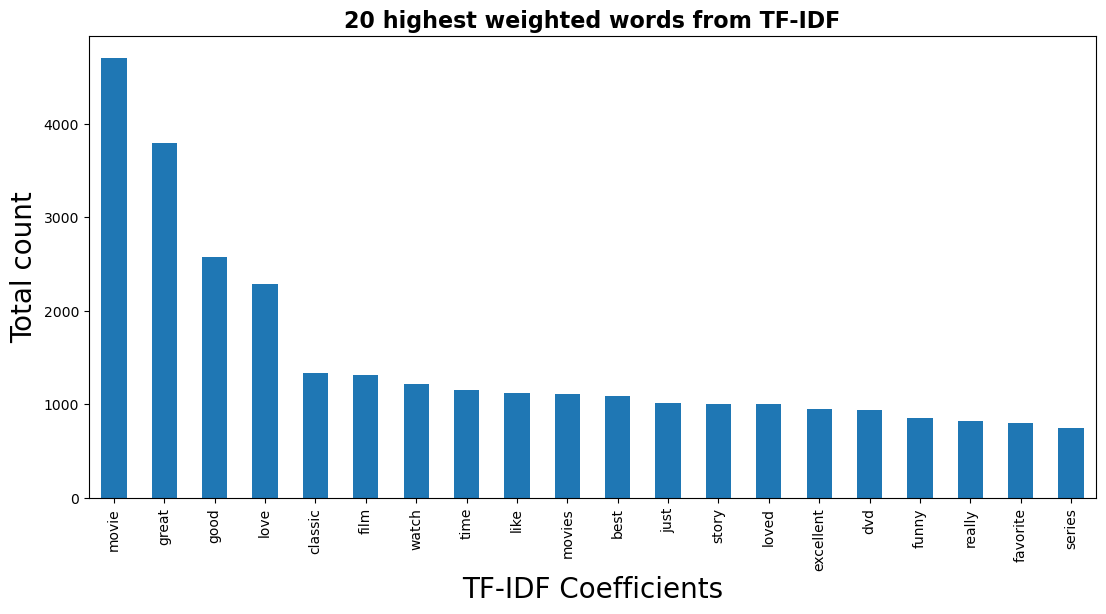

In [16]:
# Plot the results
word_counts.head(20).plot(kind="bar",figsize=(13,6), legend = False)

# Label the plot
plt.title('20 highest weighted words from TF-IDF', fontweight = 'bold', fontsize =16)
plt.xlabel('TF-IDF Coefficients', fontsize = 20)
plt.ylabel('Total count', fontsize = 20)

plt.show()

The words that appear the most often are mainly positive and this is due to the imbalanced dataset. This high count of positive words will likely skew the results to predict more positive than negative reviews. Since this is a preliminary analysis, for future work, the positive reviews will be downsampled to have a similar distribution for positive and negative reviews.

Now that the text features are encoded into sparse matrices, they will need to be turned into arrays to be used in the advanced models.

In [17]:
# Turn the sparse matrices into arrays
X_train_transformed = X_train_transformed.toarray()
X_test_transformed = X_test_transformed.toarray()

Now that the text features are arrays, they can be used in advanced models.

# 5. Advanced Models <a class ='anchor' id='5AdvancedModels'></a>

The numeric features will have to be normalized before they are used in the models. A standard scaler will be used to normalize the data to make the mean 0 and have a variance of 1.

In [18]:
from sklearn.preprocessing import StandardScaler

# Instantiate
standscaler = StandardScaler()
standscaler.fit(X_train_transformed)

# Transform both the X train and X test data
X_train_scaled = standscaler.transform(X_train_transformed)
X_test_scaled = standscaler.transform(X_test_transformed)

Now that the features have been normalized, they can now be used in the machine learning models.

## 5.1 Logistic Regression<a class ='anchor' id='5.1logit'></a>

A logistic regression model will be trained to fit the text features.

In [33]:
from sklearn.linear_model import LogisticRegression

# Instantiate
logreg = LogisticRegression(C = 0.1)

# Fit the model
logreg.fit(X_train_scaled,y_train)

# Score the model
print(f"Train score: {logreg.score(X_train_scaled,y_train)}")
print(f"Test score: {logreg.score(X_test_scaled,y_test)}")

Train score: 0.935823754789272
Test score: 0.8677281077770974


The results are better than the models ran in notebook 2_Modelling_without_text_data. The test scores are 3% higher which can indicate that the text features have predictive power in predicting the sentiment from reviews. The coefficients will be explored to further evaluate the model.

In [37]:
# Save the above model
pickle.dump(logreg, open('Saved_Models/3_logreg_model.pickle','wb'))

In [38]:
# Load the saved model
logreg = pickle.load(open('Saved_Models/3_logreg_model.pickle','rb'))

In [39]:
# Determine the model coefficients
logreg.coef_[0]

array([-0.00950982, -0.00204652,  0.00722454, ...,  0.00056862,
       -0.04195312,  0.00221112])

In [40]:
# Show which column the coefficient is referring to.
review_wordbank.get_feature_names()

['00',
 '000',
 '007',
 '10',
 '100',
 '1000',
 '101',
 '101st',
 '1080p',
 '10th',
 '11',
 '12',
 '13',
 '13th',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '1930',
 '1930s',
 '1939',
 '1940',
 '1940s',
 '1941',
 '1942',
 '1944',
 '1945',
 '1950',
 '1950s',
 '1951',
 '1954',
 '1955',
 '1957',
 '1958',
 '1959',
 '1960',
 '1960s',
 '1961',
 '1962',
 '1963',
 '1964',
 '1965',
 '1966',
 '1967',
 '1968',
 '1969',
 '1970',
 '1970s',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1980s',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1990s',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '19th',
 '1st',
 '20',
 '200',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '20th',
 '21',
 '21st',
 '22',
 '23',
 '24',
 '25',
 '25th',
 '26',
 '27',
 '28',
 '29',
 '2nd',
 '30'

The coefficients and feature names are found above separately but they can be combined into a dataframe to better visualize which coefficients belong to which features.

In [41]:
# Turn the above into a dataframe to be used in a horizontal barplot.
coeff_df = pd.DataFrame({"coefficients": logreg.coef_[0]}, index = review_wordbank.get_feature_names()).sort_values('coefficients', ascending = True)

# Check results
coeff_df

,coefficients
waste,-0.383933
boring,-0.301413
terrible,-0.262718
dreadful,-0.254481
utf8,-0.248075
...,...
loved,0.547270
awesome,0.689664
excellent,0.731739
love,0.800651


The coefficients and features are shown above but bar plots can be made to visualize the results better.

**Features to predict negative sentiment**

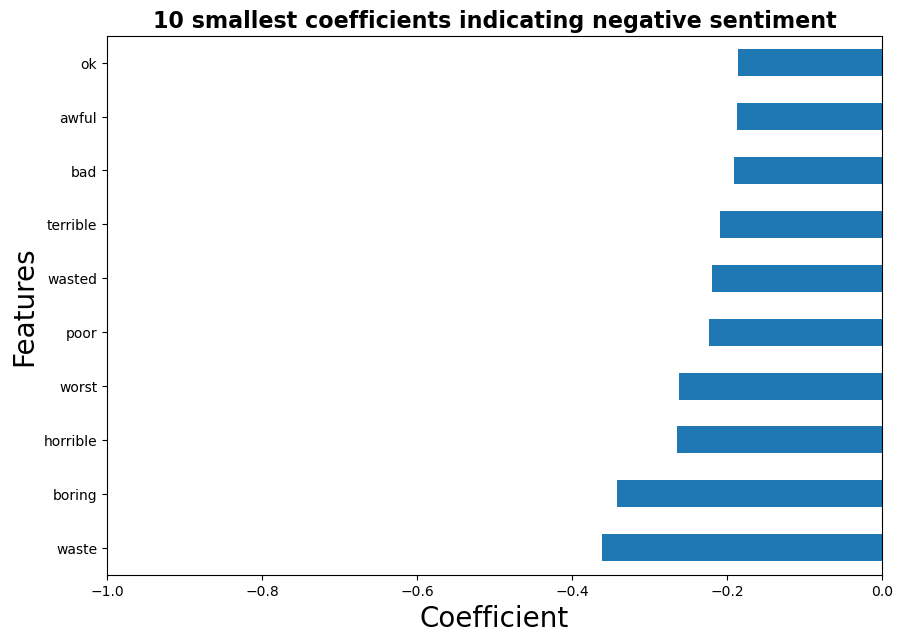

In [25]:
# Make a horizontal bar plot
coeff_df.head(10).plot(kind = 'barh', figsize = (10,7),legend = False)

# Set x axis range
plt.xlim([-1,0])

# Label the plot
plt.title('10 smallest coefficients indicating negative sentiment', fontweight = 'bold', fontsize =16)
plt.xlabel('Coefficient', fontsize = 20)
plt.ylabel('Features', fontsize = 20)

plt.show()

The plot above shows that the logistic model is able to pick up on some negative features like `boring`, `waste`, `horrible` etc. Although these may be used to predict the negative sentiment, the absolute value of the coefficients is small. These small values may lead to a decreased performance for predicting negative sentiment.

**Features to predict positive sentiment**

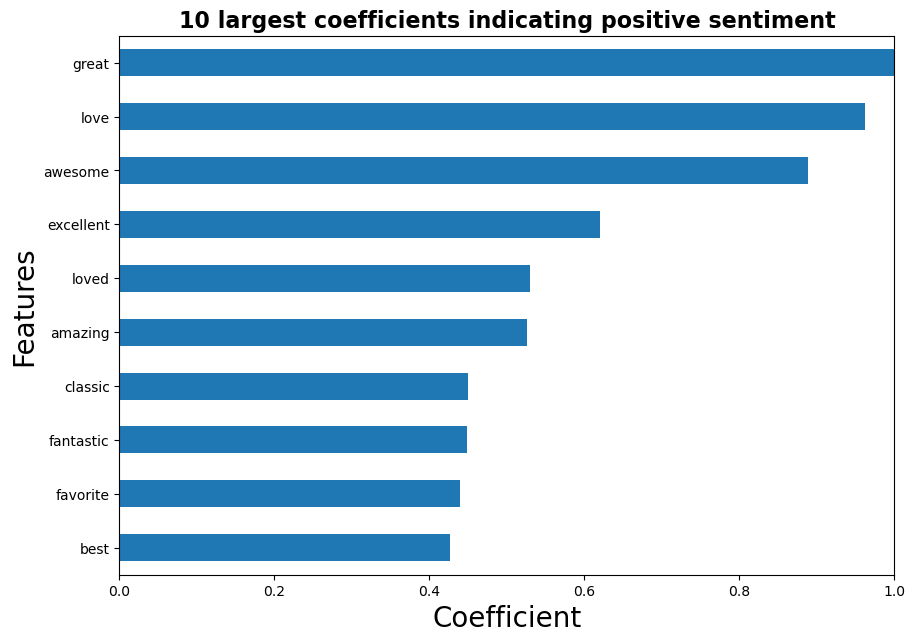

In [26]:
# Make a horizontal bar plot
coeff_df.tail(10).plot(kind = 'barh', figsize = (10,7),legend = False)

# Set x axis range
plt.xlim([0,1])

# Label the plot
plt.title('10 largest coefficients indicating positive sentiment', fontweight = 'bold', fontsize =16)
plt.xlabel('Coefficient', fontsize = 20)
plt.ylabel('Features', fontsize = 20)

plt.show()

From the coefficient plot above, it can be seen that there are some features that almost have a coefficient of 1 which is relatively high compared to every other coefficient. This makes it so that if there is the word `love` in the text, there is a higher probability that the model will predict it to be positive.

The classification report and confusion matrix can be used to see the recall and precision of the model. The imported plotting functions will be used.

In [27]:
# Determine the precision and recall of the model
class_report(logreg,X_test_scaled,y_test)

              precision    recall  f1-score   support

           0       0.60      0.57      0.59      3541
           1       0.92      0.92      0.92     17688

    accuracy                           0.86     21229
   macro avg       0.76      0.75      0.75     21229
weighted avg       0.86      0.86      0.86     21229



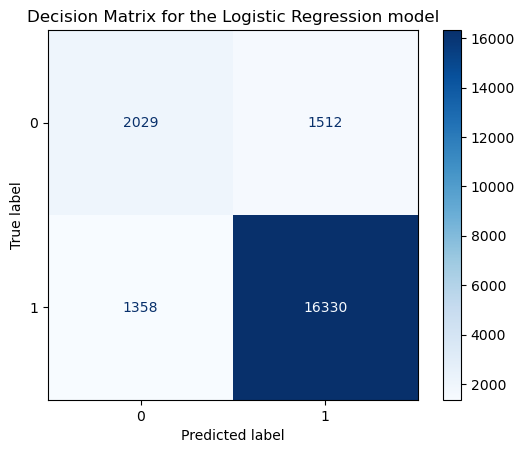

In [28]:
# Plot the decision matrix
conf_matrix(logreg,X_test_scaled,y_test, 'Logistic Regression')

The results from the above show that the model is performing better than the logistic regression model without the text features. Even though the sample size is smaller than in notebook 2_Modelling_without_text_data, the logistic regression model is able to generalize better to the test data in predicting the sentiment of the review. The recall and precision for predicting negative sentiment are better than 50% which is a good start in determining the best model to fit this text data. For future work, the logistic regression model will be optimized by tuning the hyperparameters.

## 5.2 Decision Tree Classification<a class ='anchor' id='5.2DT'></a>

In this section, a decision tree will be used to model the data.

In [29]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate
decisiontree_model = DecisionTreeClassifier(max_depth = 4)

# Fit the model
decisiontree_model.fit(X_train_transformed,y_train)

# Score the model
print(f"Train score: {decisiontree_model.score(X_train_transformed,y_train)}")
print(f"Test score: {decisiontree_model.score(X_test_transformed,y_test)}")

Train score: 0.844199484956975
Test score: 0.842620943049602


The accuracy of the decision tree is relatively low compared to the baseline of 0.835. The precision and recall will be explored further.

The above model can be saved so this notebook can be run without fitting the model again.

In [30]:
# Save the above model
pickle.dump(decisiontree_model, open('Saved_Models/3_decisiontree_model.pickle','wb'))

In [31]:
# # Load the saved model
decisiontree_model = pickle.load(open('Saved_Models/3_decisiontree_model.pickle','rb'))

The classification report and decision matrix will be determined below to look at the precision and recall of the model.

In [32]:
# Determine the precision and recall of the model
class_report(decisiontree_model,X_test_transformed,y_test)

              precision    recall  f1-score   support

           0       0.61      0.16      0.26      3541
           1       0.85      0.98      0.91     17688

    accuracy                           0.84     21229
   macro avg       0.73      0.57      0.58     21229
weighted avg       0.81      0.84      0.80     21229



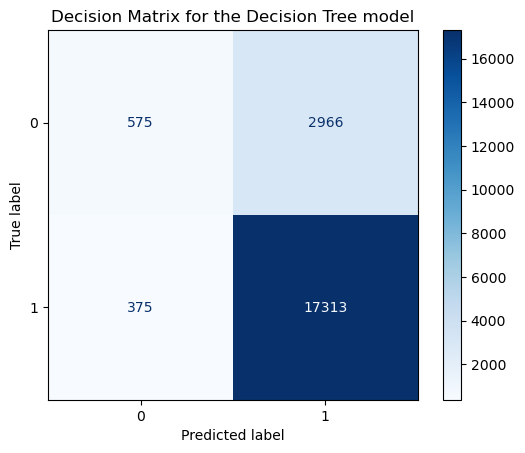

In [33]:
# Plot the decision matrix
conf_matrix(decisiontree_model,X_test_transformed,y_test, 'Decision Tree')

The recall for this model is not good for predicting negative sentiment which is the same case as determined in the decision tree model from Notebook 2. 

## 5.3 XGBoost<a class ='anchor' id='5.3xgboost'></a>

In this section, a XGBoost model will be used to fit the data.

In [45]:
from xgboost import XGBClassifier

# Instantiate model
XGB_model = XGBClassifier(scale_pos_weight = 0.3)

# Fit model
XGB_model.fit(X_train_scaled,y_train)

# Score the model
print(f"Train score: {XGB_model.score(X_train_scaled,y_train)}")
print(f"Test score: {XGB_model.score(X_test_scaled,y_test)}")

Train score: 0.901183970856102
Test score: 0.867304159404588


In [46]:
X_train_scaled.shape

(63684, 7722)

The train and test accuracy from this model is the highest out of all the tried models. This is a good sign that this model may be great for sentiment predictions. To further evaluate the results, the recall and precision scores will be analyzed.

The above model can be saved so this notebook can be run without fitting the model again.

In [47]:
# Save the above model
pickle.dump(XGB_model, open('Saved_Models/3_XGBoost_model.pickle','wb'))

In [48]:
# # Load the saved model
XGB_model = pickle.load(open('Saved_Models/3_XGBoost_model.pickle','rb'))

**Feature Importance Plot**

In [49]:
# Turn the above into a dataframe to be used in a horizontal barplot.
coeff_df = pd.DataFrame({"coefficients": XGB_model.feature_importances_},  index = review_wordbank.get_feature_names()).sort_values('coefficients', ascending = True)

# Check results
coeff_df.tail(10)

,coefficients
predictable,0.008546
love,0.008575
ok,0.008896
awesome,0.009138
poor,0.009525
worst,0.009790
loved,0.011094
boring,0.012195
bad,0.013302
waste,0.018380


In [50]:
# Reset the index
coeff_df.reset_index(inplace = True)

# Check results
coeff_df

,index,coefficients
0,00,0.000000
1,phones,0.000000
2,phone,0.000000
3,phoenix,0.000000
4,philosophy,0.000000
...,...,...
7717,worst,0.009790
7718,loved,0.011094
7719,boring,0.012195
7720,bad,0.013302


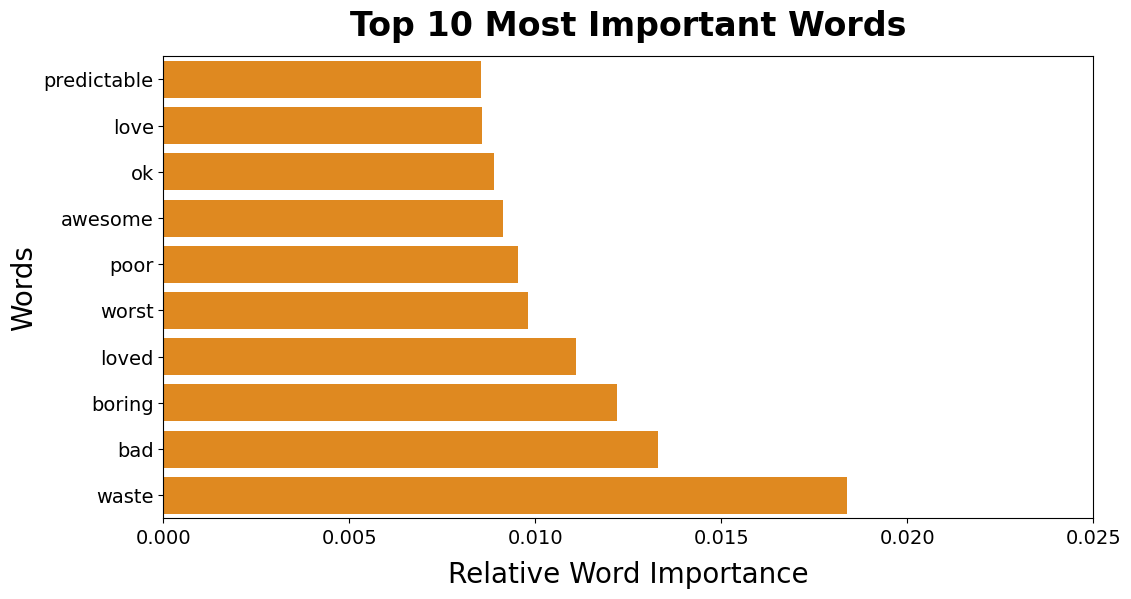

In [51]:
import seaborn as sns

plt.figure(figsize = (12,6))

# Separate the count of the values in the specific column
y_val = coeff_df['index'].tail(10)
x_val = coeff_df['coefficients'].tail(10)

# Make the barplot
sns.barplot(x = x_val, y = y_val, data = coeff_df, color = 'darkorange')

plt.xlim([0,0.025])
# Label the plot
plt.title(f'Top 10 Most Important Words', fontweight = 'bold', fontsize = 24, pad = 15)
plt.xlabel('Relative Word Importance', fontsize = 20, labelpad=10)
plt.ylabel('Words', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

The most import features are shown in the plot above for the XGBoost model. There are some words that are more important than others like `waste` or `money`.

The classification report and decision matrix will be determined below to look at the precision and recall of the model.

In [90]:
# Determine the precision and recall of the model
class_report(XGB_model,X_test_scaled,y_test)

              precision    recall  f1-score   support

           0       0.70      0.54      0.61      3552
           1       0.91      0.95      0.93     17677

    accuracy                           0.88     21229
   macro avg       0.80      0.75      0.77     21229
weighted avg       0.88      0.88      0.88     21229



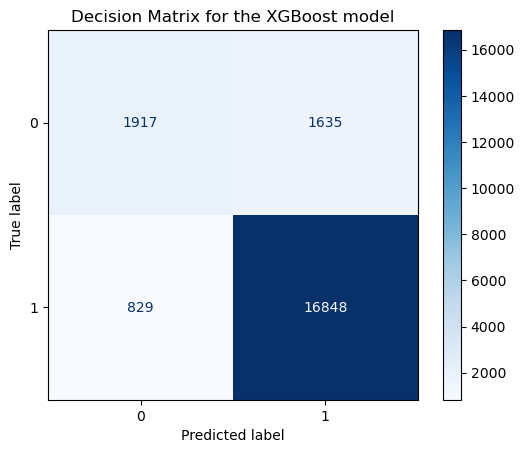

In [89]:
# Plot the decision matrix
conf_matrix(XGB_model,X_test_scaled,y_test, 'XGBoost')

The recall for negative predictions is relatively low but this is better than the XGboost model in Notebook 2. This model shows promising results that can be improved with more hyperparameter tuning in the future. The high precision for sentiment prediction makes this a great model to move forward with in the future.

# 6. Summary<a class ='anchor' id='6summary'></a>

The logistic regression model gave decent results for predicting the sentiment and the most important features/coefficients were also determined in section 5.1. The coefficients were mainly high positive values which are mainly influenced by a large number of positive reviews in the dataset. The decision tree model did not show promising results and should not be used in the predicting sentiment. The XGBoost model showed very promising results for predicting sentiment as the precision was fairly high for both positive and negative predictions.